Purpose of segmentation: for biomedical segmentation/classification (TODO: what else?)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from fastai.utils.collect_env import *
show_install()

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

import gc
np.random.seed(seed)

# Get data

In [4]:
path = untar_data(URLs.CAMVID_TINY)
path_lbls = path
path.ls()

[PosixPath('/home/quantran/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/home/quantran/.fastai/data/camvid_tiny/labels'),
 PosixPath('/home/quantran/.fastai/data/camvid_tiny/images')]

In [9]:
path_lbl = path/'labels'
path_img = path/'images'

In [34]:
path_img.ls()[:2]

[PosixPath('/home/quantran/.fastai/data/camvid_tiny/images/0001TP_009840.png'),
 PosixPath('/home/quantran/.fastai/data/camvid_tiny/images/Seq05VD_f04950.png')]

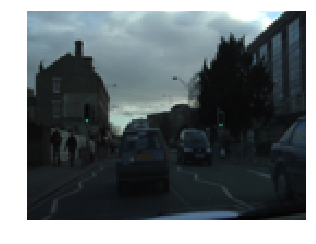

In [32]:
img_f = path_img.ls()[0]
open_image(img_f).show(figsize=(5,5))

In [33]:
path_lbl.ls()[:2]

[PosixPath('/home/quantran/.fastai/data/camvid_tiny/labels/Seq05VD_f02880_P.png'),
 PosixPath('/home/quantran/.fastai/data/camvid_tiny/labels/0006R0_f03180_P.png')]

Mask ('label') will be treated as 'ImageSegment' object (different lighting, different convert mode) -> use ```open_mask```

In [35]:
img_f

PosixPath('/home/quantran/.fastai/data/camvid_tiny/images/0001TP_009840.png')

In [36]:
img_f.stem
img_f.suffix

'0001TP_009840'

'.png'

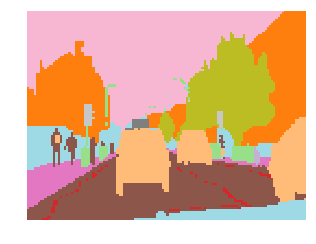

In [37]:
mask = open_mask(path_lbl/f'{img_f.stem}_P{img_f.suffix}')
mask.show(figsize=(5,5),alpha=1)

In [72]:
mask.shape

torch.Size([1, 96, 128])

Label Y is a matrix same size as image, with each pixel is labeled as a class

In [45]:
mask.data

tensor([[[21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [46]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [75]:
codes[21],codes[4],codes[17],codes[30]

('Sky', 'Building', 'Road', 'Void')

Mask size is the same for all images. Image size is the same as well

In [51]:
for f in path_img.ls()[:3]:
    print(open_image(f).shape[1:])
print('---')
for f in path_lbl.ls()[:3]:
    print(open_mask(f).shape[1:])


torch.Size([96, 128])
torch.Size([96, 128])
torch.Size([96, 128])
---
torch.Size([96, 128])
torch.Size([96, 128])
torch.Size([96, 128])


In [56]:
src_size = np.array(open_image(img_f).shape[1:])

In [57]:
src_size

array([ 96, 128])

# Prepare dataset

In [78]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [116]:
bs=8
src = (SegmentationItemList.from_folder(path_img)
       # technically random split for val set is bad, because this dataset is video frame.
        .random_split_by_pct()
       # label: mask path associated with the image
        .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=bs)
       .normalize(imagenet_stats))

In [100]:
data.train_ds[0]

(Image (3, 128, 128), ImageSegment (1, 128, 128))

In [101]:
data.train_ds[0][1].data[0]

tensor([[21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        ...,
        [30, 30, 30,  ..., 17, 17, 17],
        [30, 30, 30,  ..., 17, 17, 17],
        [30, 30, 30,  ..., 17, 17, 17]])

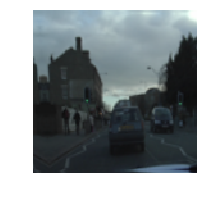

In [102]:
data.train_ds[0][0].show()

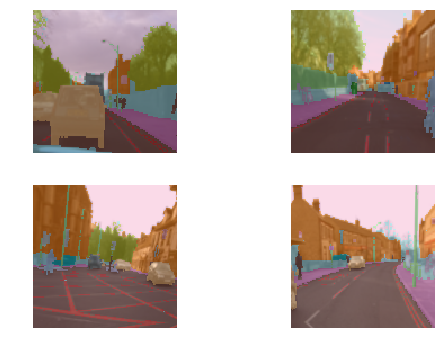

In [83]:
data.show_batch(2, figsize=(8,5))

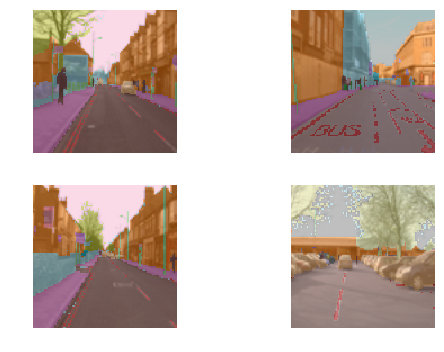

In [84]:
data.show_batch(2, figsize=(8,5),ds_type=DatasetType.Valid)

Loss function

In [103]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

# Model

In [117]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [106]:
len(name2id)

32

In [105]:
void_code

30

In [118]:
def acc_camvid(input, target):
    '''
    Get accuracy for each pixel (excluding void) and take the mean of all accuracies
    '''
    #prediction(input) shape: (bs,# classes,128,128)
    #label(target) shape: (bs,1,128,128)
    target = target.squeeze(1) # get rid of 1 in label
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# metrics=accuracy
metrics=acc_camvid

In [110]:
# wd=1e-2

In [119]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


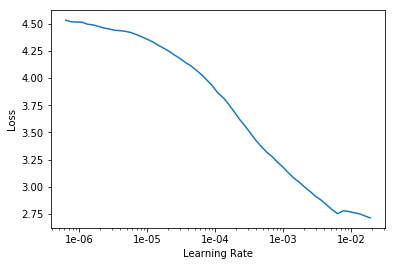

In [120]:
lr_find(learn)
learn.recorder.plot()

In [156]:
lr=3e-4

In [157]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,3.424660,3.046231,0.278935
2,3.029378,2.247870,0.496984
3,2.645981,1.746907,0.647654
4,2.319970,1.430314,0.686717
5,2.036269,1.267679,0.687663
6,1.837591,1.161773,0.707259
7,1.662065,0.979050,0.773609
8,1.497192,0.867828,0.800315
9,1.362989,0.859233,0.788271
10,1.249681,0.787991,0.814451


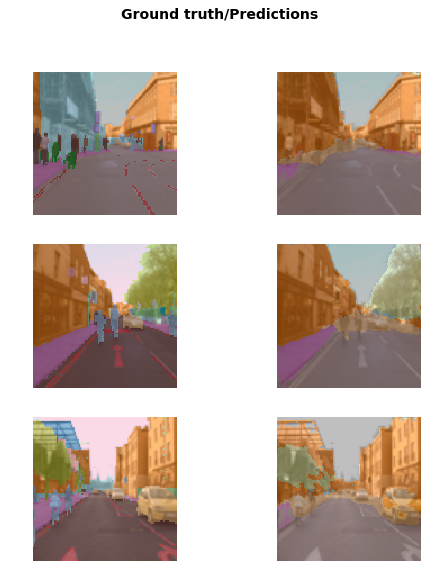

In [122]:
learn.show_results(rows=3, figsize=(8,9))

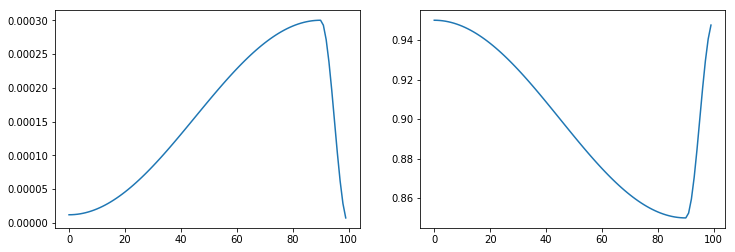

In [159]:
learn.recorder.plot_lr(show_moms=True)

## Default pct_start (0.3)

In [155]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [150]:
lr=3e-4

learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid
1,4.403256,3.212298,0.302548
2,3.374396,1.841767,0.561246
3,2.645111,1.367619,0.666378
4,2.189112,1.148167,0.714247
5,1.877085,1.057460,0.740123
6,1.635556,0.890385,0.792439
7,1.450747,0.836571,0.805696
8,1.310510,0.816492,0.805099
9,1.198394,0.812087,0.809521
10,1.118224,0.808127,0.811059


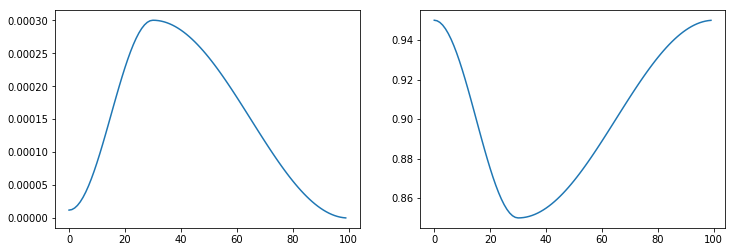

In [154]:
learn.recorder.plot_lr(show_moms=True)

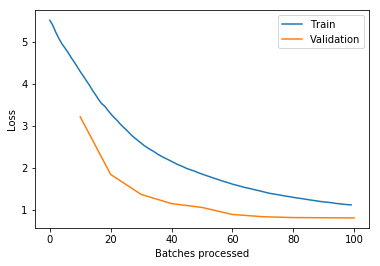

In [152]:
learn.recorder.plot_losses()

# Prediction

## 1 image

In [137]:
img = data.train_ds[0][0]
pred_class,pred_idx,probs=learn.predict(img)

In [140]:
pred_class.data

tensor([[[21, 21, 21,  ..., 21, 21,  4],
         [21, 21, 21,  ...,  4, 21,  4],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [18, 17, 30,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [ 9,  9, 17,  ..., 17, 17, 17]]])

In [141]:
pred_idx

tensor([[[21, 21, 21,  ..., 21, 21,  4],
         [21, 21, 21,  ...,  4, 21,  4],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [18, 17, 30,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [ 9,  9, 17,  ..., 17, 17, 17]]])

In [146]:
probs[0]

tensor([[0.0261, 0.0102, 0.0037,  ..., 0.0192, 0.0234, 0.0306],
        [0.0273, 0.0179, 0.0075,  ..., 0.0167, 0.0175, 0.0205],
        [0.0117, 0.0061, 0.0025,  ..., 0.0086, 0.0087, 0.0127],
        ...,
        [0.0013, 0.0010, 0.0007,  ..., 0.0009, 0.0019, 0.0053],
        [0.0017, 0.0013, 0.0012,  ..., 0.0014, 0.0028, 0.0061],
        [0.0032, 0.0041, 0.0028,  ..., 0.0026, 0.0044, 0.0122]])

## from dataset

In [160]:
probs,y_true,losses=learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)

In [163]:
len(data.valid_ds)

20

In [164]:
probs.shape

torch.Size([20, 32, 128, 128])

In [166]:
probs[0][0]

tensor([[2.5201e-02, 2.3858e-02, 1.4554e-02,  ..., 1.0547e-03, 4.2084e-03,
         7.1657e-03],
        [1.8084e-02, 1.0948e-02, 1.0153e-02,  ..., 3.7604e-04, 1.0811e-03,
         4.1280e-03],
        [1.5906e-02, 7.9853e-03, 7.2114e-03,  ..., 5.4599e-04, 1.5852e-03,
         3.5091e-03],
        ...,
        [7.0999e-03, 1.3593e-03, 5.0575e-04,  ..., 8.7147e-05, 2.6900e-04,
         1.1897e-03],
        [8.5609e-03, 2.2569e-03, 8.1966e-04,  ..., 3.8112e-04, 9.1771e-04,
         3.0257e-03],
        [1.2113e-02, 4.0947e-03, 1.8564e-03,  ..., 2.0515e-03, 3.2085e-03,
         1.0158e-02]])

In [165]:
y_true.shape

torch.Size([20, 1, 128, 128])

In [167]:
y_true[0][0]

tensor([[ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]])

In [168]:
losses.shape # each img in batch has 128^2 losses, one for each pixel

torch.Size([327680])